# Solving the linear system

After discretising the integral operator we need to solve the resulting linear sytem of equations. Depending on the size of the system we can use either a direct LU decomposition or use an iterative solver. In the following we will give a few remarks to both types of solvers.

As canonical examples we will consider the following two problems.

- Solution of the single-layer boundary integral equation discretised as $A_Vx = b$
with 

$$
[A_V][i, j] = \int_{\tau_i}\int_{\tau_j}g(x, y)ds(y)ds(x).
$$

- Solution of the double-layer boundary integral equation discretised as $A_Kx = b$
with

$$
[A_K][i, j] = \frac{1}{2}\int_{\tau_i\cap\tau_j}1ds(x)ds(y) - \int_{\tau_i}\int_{\tau_j}\frac{\partial g(x, y)}{\partial n(y)}ds(y)ds(x)
$$

In both cases the trial and test spaces are simply the spaces of piecewise constant functions on each triangle.


## Setting up the test problems

We first setup the test problems. We will setup a larger problem for testing iterative solvers and a smaller problem
to approximate the eigenvalues and draw them. This ensures that the notebook still runs in reasonable time.

In [1]:
import bempp.api

bempp.api.enable_console_logging()
grid_large = bempp.api.shapes.regular_sphere(6)
space_large = bempp.api.function_space(grid_large, "DP", 0)

ident_large = bempp.api.operators.boundary.sparse.identity(space_large, space_large, space_large)
op_v_large = bempp.api.operators.boundary.laplace.single_layer(space_large, space_large, space_large)
op_k_large = .5 * ident_large - bempp.api.operators.boundary.laplace.double_layer(space_large, space_large, space_large)

A_v_large = op_v_large.weak_form().A
A_k_large = op_k_large.weak_form().A
M_large = ident_large.weak_form().A

grid_small = bempp.api.shapes.regular_sphere(3)
space_small = bempp.api.function_space(grid_small, "DP", 0)

ident_small = bempp.api.operators.boundary.sparse.identity(space_small, space_small, space_small)
op_v_small = bempp.api.operators.boundary.laplace.single_layer(space_small, space_small, space_small)
op_k_small = .5 * ident_small - bempp.api.operators.boundary.laplace.double_layer(space_small, space_small, space_small)

A_v_small = op_v_small.weak_form().A
A_k_small = op_k_small.weak_form().A
M_small = ident_small.weak_form().A



fun_large = bempp.api.GridFunction.from_random(space_large)
b_large = fun_large.projections()

fun_small = bempp.api.GridFunction.from_random(space_small)
b_small = fun_small.projections()

bempp:HOST:INFO: Created grid with id 678f12e3-e5bf-4d61-8f49-1a7d783f5688. Elements: 32768. Edges: 49152. Vertices: 16386
bempp:HOST:INFO: OpenCL CPU Device set to: AMD Ryzen Threadripper 3970X 32-Core Processor 
/home/betcke/miniconda3/envs/dev/lib/python3.9/site-packages/pyopencl/__init__.py:274: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "
/home/betcke/miniconda3/envs/dev/lib/python3.9/site-packages/pyopencl/__init__.py:274: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "
bempp:HOST:INFO: Created grid with id 2a9d198c-fe2a-47db-82be-d8b572d60833. Elements: 512. Edges: 768. Vertices: 258


## Direct solution via LU decomposition

The easiest way to solve the discrete problem is via LU decomposition. Moreover, it is very efficient if we want to solve problems with many right-hand sides. The disadvantage though is that the cost of a dense LU decomposition scales like $\mathcal{O}(n^3)$ with $n$ the dimension of the discrete problem.

In Python we can simply use the Numpy dense solver, which uses LAPACK for solving linear systems of equations.

In [2]:
import numpy as np

xvlu = np.linalg.solve(A_v_small, b_small)
xklu = np.linalg.solve(A_k_small, b_small)

We have used here the small mesh. The larger mesh with $32k$ elements would already be too large for some standard desktop computers to handle in reasonable time.

## Iterative solvers

Discrete boundary integral equations are mostly solved by iterative solvers. Typical solvers are CG (Conjugate Gradients) for symmetric positive definite systems (e.g. the Laplace single-layer operator), and GMRES (Generalized minimal residual) for nonsymmetric problems. The convergence of iterative solvers strongly depends on the distribution of the eigenvalues of the matrices. Without going into the theory, the eigenvalues should be clustered and away from zero to guarantee fast convergence. Let's plot the eigenvalues of $M^{-1}A_V$ and $M^{-1}A_K$, where $M$ is the discrete representation of the identity matrix. The matrix $M$ ensures that the scaling is correct so that we approximate the eigenvalues of the actual operators.

Text(0.5, 1.0, 'Double-Layer')

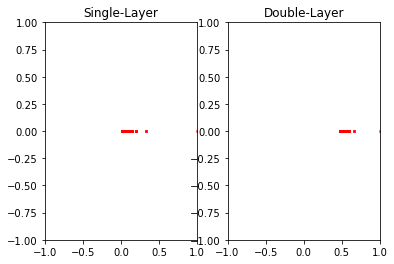

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.linalg import eigvals

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

eigv = eigvals(A_v_small, M_small.todense())
eigk = eigvals(A_k_small, M_small.todense())

ax1.plot(np.real(eigv), np.imag(eigv), 'rx', markersize=2)
ax2.plot(np.real(eigk), np.imag(eigk), 'rx', markersize=2)
ax1.axis([-1, 1, -1, 1])
ax2.axis([-1, 1, -1, 1])

ax1.set_title("Single-Layer")
ax2.set_title("Double-Layer")

We see that in the single-layer operator has eigenvalues clustered around zero and the double-layer operator has eigenvalues clustered around $0.5$. This means that the convergence for the double-layer operator will be much better with iterative solvers. Let's try this out.

In [4]:
x, res, it_count = bempp.api.gmres(op_v_large, fun_large, use_strong_form=True, return_residuals=True)

/home/betcke/miniconda3/envs/dev/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
bempp:HOST:INFO: Starting GMRES iteration
bempp:HOST:INFO: GMRES Iteration 1 with residual 0.9253974258008764
bempp:HOST:INFO: GMRES Iteration 2 with residual 0.8299327427756287
bempp:HOST:INFO: GMRES Iteration 3 with residual 0.7531377287864541
bempp:HOST:INFO: GMRES Iteration 4 with residual 0.6393975067816466
bempp:HOST:INFO: GMRES Iteration 5 with residual 0.5584504126915677
bempp:HOST:INFO: GMRES Iteration 6 with residual 0.4762188082219082
bempp:HOST:INFO: GMRES Iteration 7 with residual 0.40116302739497317
bempp:HOST:INFO: GMRES Iteration 8 with residual 0.33486056760154237
bempp:HOST:INFO: GMRES Iteration 9 with residual 0.27472375631340423
bempp:HOST:INFO: GMRES Iteration 10 with residual 0.22319934755678547
bempp:HOST:INFO: GMRES Iteration 11 with res

Text(0.5, 1.0, 'Convergence for the single-layer operator.')

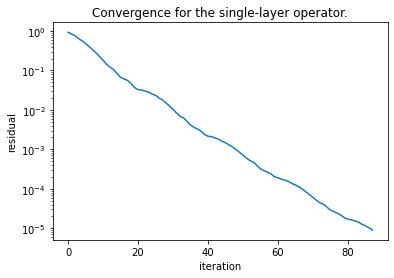

In [5]:
plt.semilogy(it_count)
plt.xlabel('iteration')
plt.ylabel('residual')
plt.title('Convergence for the single-layer operator.')

bempp:HOST:INFO: Starting GMRES iteration
bempp:HOST:INFO: GMRES Iteration 1 with residual 0.011740362184927824
bempp:HOST:INFO: GMRES Iteration 2 with residual 0.0032789275004399877
bempp:HOST:INFO: GMRES Iteration 3 with residual 0.00035811035485506035
bempp:HOST:INFO: GMRES Iteration 4 with residual 2.633118193451425e-05
bempp:HOST:INFO: GMRES Iteration 5 with residual 1.3958641362734612e-06
bempp:HOST:INFO: GMRES finished in 5 iterations and took 1.19E+00 sec.


Text(0.5, 1.0, 'Convergence for the double-layer operator.')

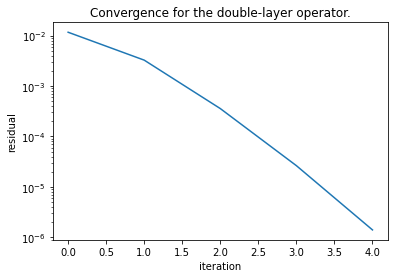

In [6]:
x, res, it_count = bempp.api.gmres(op_k_large, fun_large, use_strong_form=True, return_residuals=True)

plt.semilogy(it_count)
plt.xlabel('iteration')
plt.ylabel('residual')
plt.title('Convergence for the double-layer operator.')

In the above two examples one notices the parameter ``use_strong_form=True``. This is the Bempp notation for using mass matrix preconditioning. This means that instead of the system $Ax=b$. We solve the system $M^{-1}Ax = M^{-1}b$, where $M$ is the discretisation of the identity matrix. This is a rescaling that removes ill-conditioning due to the size of the elements.

More generally, preconditioners are matrices $P$, such that iterative solvers for $P^{-1}Ax = P^{-1}b$ converge faster to the correct solution than just iterative solvers applied to the equation $Ax=b$.

While the double-layer operator converges in just a few iterations the single-layer operator takes much longer. This is due to its eigenvalues being clustered around zero. Integral equations with $\frac{1}{2}I-K$ are also called Fredholm integral equations of the second kind while equations with the operator $V$ on the left-hand side are called Fredholm integral operators of the first kind.

For second kind integral equations mass matrix preconditioning is sufficient. For first kind integral equations we often want more sophisticated operator preconditioners such that $P^{-1}A$ has eigenvalues clustered away from zero.

We note that we could have used CG as iterative solver for the single-layer operator $V$. The reason is that internally Bempp ignores that $M^{-1}A_K$ could be solved as a preconditioned positive definite system and treats it as un unsymmetric system. By extracting the matrices and using an external routine one could circumvent this.